# Elements logiciels pour le traitement des données en grande dimension

In [1]:
%matplotlib inline

## Installation de pyspark

In [2]:
import findspark
sparkHome = "C:\Dev\Spark\spark-2.2.0-bin-hadoop2.7"
findspark.init(sparkHome)

### Petit essai pour calculer PI

In [3]:
def printSpendTime (startTime) :
    spendTime = time.time() - startTime
    m, s = divmod(spendTime, 60)
    h, m = divmod(m, 60)
    print("--------------------------------------------------")
    print ("-----   Temps écoulé : %dh%02dm%02ds" % (h, m, s))
    print("--------------------------------------------------")
    return

In [4]:
import pyspark
import random
import time

startTime = time.time()

sc = pyspark.SparkContext(appName="Pi")
num_samples = 100000000

def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1

count = sc.parallelize(range(0, num_samples)).filter(inside).count()

pi = 4 * count / num_samples
print(pi)

sc.stop()

printSpendTime(startTime)

3.14164324
--------------------------------------------------
-----   Temps écoulé : 0h00m26s
--------------------------------------------------


## Arbre k-d classique

### Création d'un jeu de données

In [5]:
import numpy as np
import pandas

n = 10
data = pandas.DataFrame(np.random.rand(n,2)*100,  columns = ['X', 'Y'])
data

,X,Y
0,99.775607,87.982218
1,88.762643,53.899344
2,78.033950,82.305234
3,57.071126,72.116465
4,8.501735,30.847856
5,59.703082,1.433271
6,59.292279,53.313280
7,78.016800,26.374647
8,48.244779,16.078803
9,67.000009,6.832904


In [6]:
data.index.values.tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

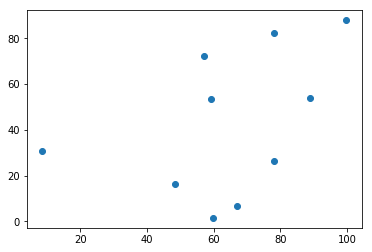

In [7]:
import matplotlib.pyplot as plt

plt.plot(data[['X']], data[['Y']], 'o')

### Arbre k-d sur ce jeu de données

In [8]:
### Class permettant de definir un arbre binaire simple
### Il se constitue d'un noeud racine, de deux sous-arbres
### et des donnees correspondant au noeud racine
class Tree(object) :
    def __init__(self) :
        self.left = None
        self.right = None
        self.key = None
        self.data = None
    
    def __str__(self) :
        return self.strRec(0)
    
    def strRec(self, depth) :
        line = "-" * 3 * depth
        res = line + str(self.data)
        if self.left :
            res += "\n" + self.left.strRec(depth+1)
        if self.right :
            res += "\n" + self.right.strRec(depth+1)
        return res

In [9]:
### Fonction recursive pour constituer un arbre k-d
def arbreKDRec (data, colList, curCol) :
    nCol = len(colList)
    nRow = data.shape[0]
    sortCol = colList[curCol]
    if nRow == 0 :
        return None
    elif nRow == 1 :
        dataNode = data.iloc[0,]
        rootNode = Tree()
        rootNode.key = sortCol
        rootNode.data = dict()
        for col in colList :
            rootNode.data[col] = dataNode[col].item()
        return rootNode
    median = int(nRow / 2)
    if nRow % 2 == 1 :
        median = int((nRow-1) / 2)
    nextCol = curCol
    if nextCol > nCol :
        nextCol = 0
    dataSort = data.sort_values(by=sortCol)
    dataNode = dataSort.iloc[median,]
    rootNode = Tree()
    rootNode.key = sortCol
    rootNode.data = dict()
    for col in colList :
        rootNode.data[col] = dataNode[col].item()
    rootNode.left = arbreKDRec(dataSort.iloc[0:median,], colList, nextCol)
    rootNode.right = arbreKDRec(dataSort.iloc[(median+1):nRow,], colList, nextCol)
    return rootNode

### Fonction englobante permettant la construction d'un arbre k-d
def arbreKD (data) :
    colList = data.columns.values.tolist()
    curCol = 0
    return(arbreKDRec(data, colList, curCol))

In [10]:
### Test de la fonction
arbre = arbreKD(data)
print(arbre)

{'X': 67.00000947175532, 'Y': 6.832903708040772}
---{'X': 57.07112636131222, 'Y': 72.11646502518508}
------{'X': 48.24477897761164, 'Y': 16.078802765559587}
---------{'X': 8.501734575402942, 'Y': 30.847855581160765}
------{'X': 59.70308224312683, 'Y': 1.4332705775011112}
---------{'X': 59.2922786283867, 'Y': 53.313279901837774}
---{'X': 88.76264300283346, 'Y': 53.89934447652314}
------{'X': 78.03395018722055, 'Y': 82.30523380680398}
---------{'X': 78.0167997938127, 'Y': 26.374646792720526}
------{'X': 99.7756069263847, 'Y': 87.98221840235279}
